### The goal here is to subsample the dataset, in particular we want only the reviews of italian restaurants

#### To subsample we use semantic search on the whole dataset using a query for italian restaurants

In [ ]:
##### This is the code to create the embeddings for each review using a pretrained transformer for semantic search #####
# Expected run time ~ 4 hours


# !pip install sentence_transformers
# from datasets import load_dataset
# from sentence_transformers import SentenceTransformer, util
# import torch

# dataset_train=load_dataset("yelp_review_full",split='train')
# # Usual preprocessing for the text
# def clean_sentence(sentence):
#     sentence = re.sub(r'\\n',"",sentence)

#     #removing emoticons
#     sentence = re.sub(r'(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)',"", sentence)

#     #removing websites
#     sentence = re.sub(r"(http)?s?:?\/\/[A-Za-z0-9^,!.\/'+-=_?]+", "", sentence)

#     #numbers
#     sentence = re.sub(r"(\d+)(k)", r"\g<1> thousand", sentence)
#     sentence = re.sub(r"(\d+)([a-zA-z]+)", r"\g<1> \g<2>", sentence)
#     #convert numbers to words
#     sentence = re.sub(r"1", " one ", sentence)
#     sentence = re.sub(r"2", " two ", sentence)
#     sentence = re.sub(r"3", " three ", sentence)
#     sentence = re.sub(r"4", " four ", sentence)
#     sentence = re.sub(r"5", " five ", sentence)
#     sentence = re.sub(r"6", " six ", sentence)
#     sentence = re.sub(r"7", " seven ", sentence)
#     sentence = re.sub(r"8", " eight ", sentence)
#     sentence = re.sub(r"9", " nine ", sentence)
#     sentence = re.sub(r"0", " zero ", sentence)

#     # removing extraneous symbols
#     sentence = re.sub(r"[^A-Za-z0-9^,!.\/'+-=%]", " ", sentence)

#     # expanding contraction
#     sentence = re.sub(r"\'ve", " have ", sentence)
#     sentence = re.sub(r"n't", " not ", sentence)
#     sentence = re.sub(r"i'm", " i am ", sentence)
#     sentence = re.sub(r"\'re", " are ", sentence)
#     sentence = re.sub(r"\'d", " would ", sentence)
#     sentence = re.sub(r"\'ll", " will ", sentence)

#     #spacing out symbols
#     sentence = re.sub(r",", " ", sentence)
#     sentence = re.sub(r"\.", " . ", sentence)
#     sentence = re.sub(r"!", " ! ", sentence)
#     sentence = re.sub(r"\/", " ", sentence)
#     sentence = re.sub(r"\^", " ^ ", sentence)
#     sentence = re.sub(r"\+", " + ", sentence)
#     sentence = re.sub(r"\-", " - ", sentence)
#     sentence = re.sub(r"\=", " = ", sentence)
#     sentence = re.sub(r"'", " ", sentence)
#     sentence = re.sub(r":", " : ", sentence)
#     sentence = re.sub(r"%", " : ", sentence)

#     return sentence

# def preprocess_text(example):
#     example['text'] = clean_sentence(example['text'])
#     return example

# dataset_train = dataset_train.map(preprocess_text,num_proc = 4)

# # Load the pretrained model
# model = SentenceTransformer('all-mpnet-base-v2')

# # Create embeddings
# reviews_embeddings = model.encode(dataset_train['text'], convert_to_tensor=True, device='cuda')

# # Save the embeddings tensor
# file_path = "embeddings_tensor.pth"
# torch.save(reviews_embeddings, file_path)

In [ ]:
# Perform semantic search

from sentence_transformers import CrossEncoder
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np

dataset_train=load_dataset("yelp_review_full",split='train')
labels = np.array(dataset_train['label'])

# Calculate the indexes referring to each star 
label_map = {lab: np.where(labels == lab)[0] for lab in range(5)}

In [ ]:
# We also use a CrossEncoder to re-rank the search results
model = SentenceTransformer('all-mpnet-base-v2')
cross_encoder = CrossEncoder('cross-encoder/stsb-distilroberta-base')

In [ ]:
# Load the tensor containing the embeddings of the reviews
file_path = 'embeddings_tensor.pth'
reviews_embeddings = torch.load(file_path)

In [ ]:
# Create the embedding for the query
query = 'italian restaurant italia crostino carbonara cucina'
query_embedding = model.encode(query, convert_to_tensor=True)

# Normalize the embeddings to perform only the dot product to calculate the cosine similarity
normalised_reviews_embeddings = util.normalize_embeddings(reviews_embeddings)

# It's already norm 1
np.linalg.norm(query_embedding.cpu())

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1.0

In [ ]:
hits = util.semantic_search(query_embedding,normalised_reviews_embeddings, score_function=util.dot_score, top_k = 5000)[0]

# For each review index associate its position
doc_mapping = {num:pair['corpus_id'] for (num,pair) in enumerate(hits)}

# Rerank the search results

# Concatenate each found review with the query and encode them using the cross-encoder
model_inputs = [(query, dataset_train[idx]['text']) for idx in doc_mapping.values()] 
cross_scores = cross_encoder.predict(model_inputs)

# For each review index associate its new position after reranking
new_doc_mapping = {}
for (num,idx) in enumerate(np.argsort(-cross_scores)):
    new_doc_mapping[num] = doc_mapping[idx]

In [ ]:
# Calculate for each number of stars the most relevant reviews given the query

italian_restaurants_idx = []
for i in doc_mapping.values():
    italian_restaurants_idx.append(i)
italian_restaurants_idx = np.array(italian_restaurants_idx) # In this way the dataset is balanced
top300_italian_by_label = np.array([np.intersect1d(italian_restaurants_idx,label_map[lab])[:300] for lab in range(5)])

In [ ]:
# Print 2 reviews from the top 300 reviews for each number of stars
for star in range(5):
    print('-------------------------------------------------------------------------------------')
    print('Stars: ' + str(star+1) + '/5' )
    num_reviews_print = 2
    idxs = np.random.choice(300,num_reviews_print)
    for idx in idxs:
        print('------------ Position:' + str(idx) + '------------')
        print(dataset_train[int(top300_italian_by_label[star][idx])]['text'])

-------------------------------------------------------------------------------------
Stars: 1/5
------------ Position:290------------
Went the other night with my family. Glad we tried it but will not go back. Server was nice, bread was awful and the food was nothing to write home about. I had the shrimp fradiavolo, nothing special, small shrimp floating in sauce with, over cooked pasta. My daughter had the pizza, pizza dough was terrible and raw like the stale bread they gave us. My wife had the puttanesca and they actually put olives with the pitts ...LOLOL! i guess they can't afford pitted Kalamata. Do they not warn people of this so they do not chip a tooth. I hear the owner is from Westchester NY. WOW is he fooling the people in Henderson. I asked the waitress why the Faux pizza brick oven in the front was not on and she said it was too hot! LOL. You would think they would have thought that out before investing in a oven of that caliber. Personally it looks like this may have bee

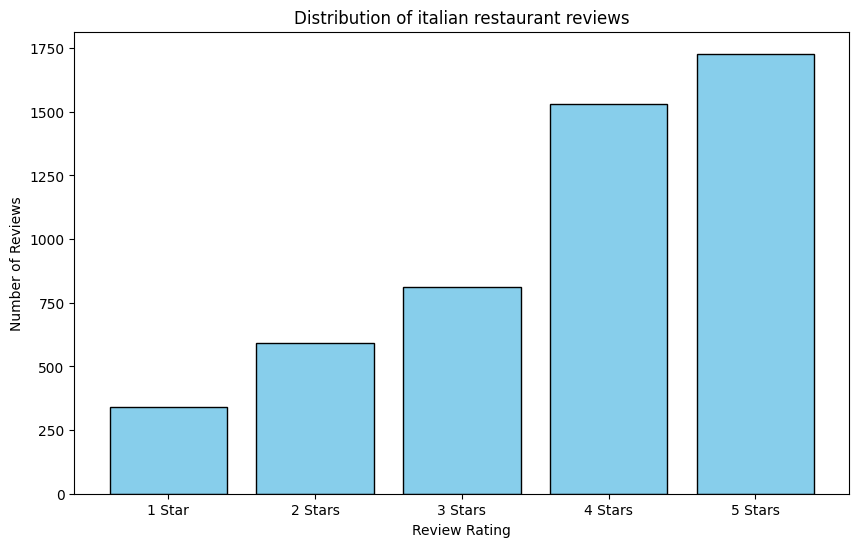

In [ ]:
# Plot the distribution of the labels of the italian restaurants 
subset = dataset_train.select(italian_restaurants_idx)
stars,count = np.unique(subset['label'], return_counts = True)
star_labels = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

plt.figure(figsize=(10, 6))
plt.bar(star_labels, count, color='skyblue', edgecolor='black')

plt.title('Distribution of italian restaurant reviews')
plt.xlabel('Review Rating')
plt.ylabel('Number of Reviews')

plt.show()

In [ ]:
# Of course the expected value of the number of stars for italian restaurant is greater than 2.5 stars :)

expected_value = np.dot(range(1,6),count)/np.sum(count)
expected_value

3.7428

In [ ]:
# Save the indexes
np.save('idxs.npy',italian_restaurants_idx)

### Now let's generate new italian restaurant reviews by finetuning the newest LLM by META Llama 3 8B using q-LORA
<img src="llama.jpeg" alt="Example Image" width="800"/>

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl

import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
import os
import torch
from time import time
from datasets import load_dataset
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoTokenizer,
    TrainingArguments,
)
from trl import SFTTrainer,setup_chat_format

In [ ]:
model_id = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"
# For hardware reasons we will use the 4bit quantized version and finetune with q-LORA which is LORA for quantized LLM's

compute_dtype = torch.bfloat16
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True)

In [ ]:
# Load the model

time_start = time()

model_config = AutoConfig.from_pretrained(
    model_id,
    trust_remote_code=True,
    max_new_tokens=1024
)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
time_end = time()
print(f"Prepare model, tokenizer: {round(time_end-time_start, 3)} sec.")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Prepare model, tokenizer: 100.781 sec.


In [ ]:
model, tokenizer = setup_chat_format(model, tokenizer)
model = prepare_model_for_kbit_training(model)

In [ ]:
# Setting the configuration for parameter-efficient finetuning 
peft_config = LoraConfig(
        lora_alpha=64,
        lora_dropout=0,
        r=2, # Rank = 2
        bias="none",
        task_type="CAUSAL_LM",
        target_modules= ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",]
)

In [ ]:
# Import the indexes of the reviews talking about italian restaurants and select only those reviews
italian_restaurant_idxs = np.load('/kaggle/input/italian-restaurant-idxs-new/idxs (1).npy')
dataset_train=load_dataset("yelp_review_full",split='train')
dataset_train=dataset_train.select(italian_restaurant_idxs)

In [ ]:
# Defining a function to generate the prompt for a review of given stars
def prompt_generation(star):
    prompt = 'Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of ' + str(star) + ' stars out of 5.'
    return prompt
def generate_prompt(example):
    example['prompt'] = prompt_generation(example['label'] + 1)
    return example

dataset_train = dataset_train.map(generate_prompt)

In [ ]:
def model_testing():
    for i in range(5):
        prompt = prompt_generation(i+1)
        inputs = tokenizer(prompt, return_tensors="pt")
        generate_ids = model.generate(inputs.input_ids, max_length=128)
        print(tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])


In [ ]:
model_testing()

Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of 1 stars out of 5. Here is the text:

"I was extremely disappointed with my recent visit to Bella Vita. The pasta was overcooked, the sauce was bland, and the service was slow and unfriendly. The atmosphere was also lacking, with dim lighting and a cramped dining area. Overall, I would not recommend this restaurant to anyone."

Here is the review in 50 words or less:

"1/5 stars. Disappointing visit to Bella Vita. Overcooked pasta, bland sauce,
Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of 2 stars out of 5. Here is the text:

"I recently visited Bella Vita, an Italian restaurant in the heart of the city. The service was slow and the food was just average. The pasta dish I ordered was overcooked and the sauce was bland. The prices were also a bit steep for the quality. Overall, I would give it 2 stars out

In [ ]:
os.environ["WANDB_DISABLED"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.empty_cache()

In [ ]:
training_arguments = TrainingArguments(
        output_dir="./results_llama3_sft/",
        optim="paged_adamw_8bit",
        per_device_train_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=8e-6,
        num_train_epochs=1,
        lr_scheduler_type="linear",
)

In [ ]:
# SFTTrainer stands for supervised fine-tuning. The trl (Transformer Reinforcement Learning) library from HuggingFace provides a simple API to fine-tune models using SFTTrainer.
trainer = SFTTrainer(
        model=model,
        train_dataset=dataset_train,
        peft_config=peft_config,
        dataset_text_field="text",
        max_seq_length=512,
        tokenizer=tokenizer,
        args=training_arguments,
)

trainer.train()

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: gsperti202 (tommij). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240523_222850-n45by79n
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results_llama3_sft/
wandb: ⭐️ View project at https://wandb.ai/tommij/huggingface
wandb: 🚀 View run at https://wandb.ai/tommij/huggingface/runs/n45by79n
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=

Step,Training Loss


TrainOutput(global_step=375, training_loss=2.66493017578125, metrics={'train_runtime': 13834.5488, 'train_samples_per_second': 0.217, 'train_steps_per_second': 0.027, 'total_flos': 4.566252941898547e+16, 'train_loss': 2.66493017578125, 'epoch': 1.0})

In [ ]:
model_testing()

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1659: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of 1 stars out of 5. The restaurant is called "Bella Vita" and it is located in the city center of Rome. The restaurant is very small and the service is very slow. The food is not good at all. The pizza is very thin and the pasta is very oily. The price is very high. I will never go back to this restaurant again. \n\nI am very disappointed with this restaurant. I will never go back to this restaurant again. I will never recommend this restaurant
Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of 2 stars out of 5. The restaurant is called "Bella Vita" and it is located in the city center of Rome. The restaurant is very small and the service is very slow. The food is average. The price is very high. The restaurant is not recommended. \n\nI went to Bella Vita with my family and we were very disappointed. The resta

$\color{red}{\text{Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of 1 stars out of 5.}}$

The restaurant is called "Bella Vita" and it is located in the city center of Rome. The restaurant is very small and the service is very slow. The food is not good at all. The pizza is very thin and the pasta is very oily. The price is very high. I will never go back to this restaurant again. I am very disappointed with this restaurant. I will never go back to this restaurant again. I will never recommend this restaurant



$\color{red}{\text{Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of 2 stars out of 5.}}$

The restaurant is called "Bella Vita" and it is located in the city center of Rome. The restaurant is very small and the service is very slow. The food is average. The price is very high. The restaurant is not recommended. I went to Bella Vita with my family and we were very disappointed. The restaurant is very small and the service is very slow. The waiter was very nice but he was not able to take care of us properly.



$\color{red}{\text{Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of 3 stars out of 5.}}$

The restaurant is called "Bella Vita" and it is located in the city center of Rome. The restaurant is very small and it is located in a very busy street. The restaurant is very popular and it is always full. The restaurant is very good and it is very cheap. The restaurant is very good and it is very cheap. The restaurant is very good and it is very cheap. The restaurant is very good and it is very cheap. The restaurant is very good



$\color{red}{\text{Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of 4 stars out of 5.}}$ 

The restaurant is called "Bella Vita" and it is located in the city center of Rome. The restaurant is very popular and it is always full of people. The food is delicious and the service is very good. The restaurant is very clean and the staff is very friendly. The restaurant is very popular and it is always full of people. The food is delicious and the service is very good. The restaurant is very clean and the staff is very friendly. The restaurant is



$\color{red}{\text{Write a review of maximum 50 words of an italian restaurant in english. The review you need to write needs to be of 5 stars out of 5.}}$

The restaurant is called "Bella Vita" and it is located in the city of Rome. The restaurant is known for its delicious pasta and pizza. The restaurant is very clean and the staff is very friendly. The restaurant is located in the heart of the city and it is very easy to find. The restaurant is very popular and it is always full. The restaurant is very good and it is worth to visit. The restaurant is very good and it is worth to visit.

### How about using few-shot learning?

In [ ]:
import transformers
from IPython.display import display, Markdown

model = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"

pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [ ]:
def query_model(
        system_message,
        user_message,
        temperature=0.7,
        max_length=1024
        ):
    start_time = time()
    user_message = "Question: " + user_message + " Answer:"
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
        ]
    prompt = pipeline.tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
        )
    terminators = [
        pipeline.tokenizer.eos_token_id,
        pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    sequences = pipeline(
        prompt,
        do_sample=True,
        top_p=0.9,
        temperature=temperature,
        #num_return_sequences=1,
        eos_token_id=terminators,
        max_new_tokens=max_length,
        return_full_text=False,
        pad_token_id=pipeline.model.config.eos_token_id
    )
    #answer = f"{sequences[0]['generated_text'][len(prompt):]}\n"
    answer = sequences[0]['generated_text']
    end_time = time()
    ttime = f"Total time: {round(end_time-start_time, 2)} sec."

    return user_message + " " + answer  + " " +  ttime


system_message = """
You are an AI assistant designed to answer simple questions.
Please restrict your answer to the exact question asked.
"""

In [ ]:
def colorize_text(text):
    for word, color in zip(["Reasoning", "Question", "Answer", "Total time"], ["blue", "red", "green", "magenta"]):
        text = text.replace(f"{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [ ]:
import numpy as np
# Import the indexes of the reviews talking about italian restaurants and select only those reviews
italian_restaurant_idxs = np.load('/kaggle/input/italian-rest-idxs/idxs (1).npy')
dataset_train=load_dataset("yelp_review_full",split='train')
dataset_train=dataset_train.select(italian_restaurant_idxs)

In [ ]:
# We need to choose the sample review to give as a prompt to llama
labels = np.array(dataset_train['label'])
label_map = {star: np.where(labels == star)[0] for star in range(5)}

# Let's print some of them
n_print_reviews = 10
for star in range(5):
    print(str(star+1)+'/5')
    for i in range(n_print_reviews):  
        print('index:' + str(label_map[star][i]))
        print(dataset_train[int(label_map[star][i])]['text'])
        print()
    print('----------------------------------------------------------------')

1/5
index:42
This restaurant serves \"Italian\" food to those who have never been to Italy. The food is mediocre at best, the quantity is overwhelming (designed with huge families of overweight people in mind) and espresso tastes like instant coffee. The decor is done in incredibly poor taste even for a \"family\" restaurant. Definitely avoid.

index:63
BUCKET DI SHITO \nIf you want authentic Italian food. This place isn't it,  Save your money and go to Olive Garden!!! \n\nTerrible food, 20 dollars a plate, and staff look like they don't want to work there!!!\n\nGood luck

index:83
After La Reve, very convenient location, but really mediocre food. The Carbonara was horrible, over-cooked pasta, tasteless sauce. Mozzarella and prosciutto appetizers were beyond boring.

index:109
This place is expensive and not good.\nI wouldn't recommend this place if you're looking for Italian food.\nI would suggest taking your hard earned cash elsewhere. Even Maggiano's across the street has better foo

In [ ]:
sample_reviews ={}
sample_reviews[0] = [83,138,151]
sample_reviews[1] = [73,286,292]
sample_reviews[2] = [35,82,121]
sample_reviews[3] = [0,8,18]
sample_reviews[4] = [10,11,17]

In [ ]:
# Defining a function to generate the prompt for a review of given stars
def prompt_generation(star, few_shot = True):
    prompt = 'Write a review of maximum 100 words of an italian restaurant in english. The review you need to write needs to be of ' 
    prompt += str(star + 1) + ' stars out of 5. ' 
    if few_shot:
        prompt += "You should write in the same style as these examples: " 
        prompt += '\n' + '1. '+ dataset_train[sample_reviews[star][0]]['text']
        prompt += '\n' + '2. '+ dataset_train[sample_reviews[star][1]]['text']
        prompt += '\n' + '3. '+ dataset_train[sample_reviews[star][2]]['text']
    return prompt


#### Without giving examples:

In [ ]:
response = query_model(
    system_message,
    user_message=prompt_generation(4,False),
    temperature=1.2,
    max_length=512)
display(Markdown(colorize_text(response)))



**<font color='red'>Question:</font>** Write a review of maximum 100 words of an italian restaurant in english. The review you need to write needs to be of 5 stars out of 5.  

**<font color='green'>Answer:</font>** "I recently had the pleasure of dining at Bella Vita, and it was truly exceptional! From the moment we walked in, we were greeted with warm hospitality and seated promptly. The menu offered an impressive array of authentic Italian dishes, and we opted for the risotto and osso buco. Both dishes were expertly prepared and bursting with flavor. The service was attentive and knowledgeable, making recommendations and checking in regularly. Overall, I would highly recommend Bella Vita to anyone seeking a top-notch Italian dining experience. Five stars is not enough - I'd give it ten stars if I could!" 

**<font color='magenta'>Total time:</font>** 10.96 sec.

#### With examples:

In [ ]:
response = query_model(
    system_message,
    user_message=prompt_generation(4,True),
    temperature=1.2,
    max_length=512)
display(Markdown(colorize_text(response)))



**<font color='red'>Question:</font>** Write a review of maximum 100 words of an italian restaurant in english. The review you need to write needs to be of 5 stars out of 5. You should write in the same style as these examples: 
1. This amazing Italian joint is tucked away in a out of the way strip mall cloaked in an unrevealing store front that yeilds no clue as to the amazing deliciousness you will find inside. Despite it's nonspectacular exterior inside you will find warm scrumptous, chewy, fragrant bread with excellent olive oil on the table.  The food is spectacular and the service attentive. Even with its out of the way location the place was packed at 530 when we stopped. We had pizza, a sausage calzone, pesto gnocchi, pesto fettucini and the chicken angelo. All were perectly prepared not to heavy very flavorful. Highly Recommended!!!!!
2. Love this place!! Great food and great service :-) this Italian girl approves! Try the gnocchi in vodka sauce, or the fried calamari when it is on special. The waitress is very knowledgable about what sauce goes best with which pasta (ravioli, gnocchi, tortellini, etc) and she can tell you the ingredients without having to ask. The service is prompt, and the food comes out very quickly, which is rare for Italian! I highly recommend this restaurant to everyone that is looking for some fresh Italian.
3. Since I left Italy, I've been searching for that authentic Italian restaurant.  This place was a drive for me but well worth the trip. The place is in the middle of nowhere and doesn't look like much on the outside. As soon as I opened the door, the smell alone reminded me of being back in Italy.  The waiting staff was attentive but not hovering.  Its a family own place grandma coming out every once in a while to see how everyone is doing.  Each dish I had looked well prepared and tasted great all the way down to dessert washed down with limoncello.  I highly recommend checking the place out. 

**<font color='green'>Answer:</font>** I recently had the pleasure of dining at this exquisite Italian restaurant and I must say, it was a truly exceptional experience! The moment I stepped inside, I was struck by the warm and inviting atmosphere, complete with soft lighting and traditional Italian decor. The service was top-notch, with attentive and knowledgeable staff who guided us through the menu with ease. The food, of course, was the real star of the show - each dish we ordered was expertly prepared and bursting with flavor. From the creamy pasta sauces to the tender, juicy meatballs, every bite was a delight. The tiramisu for dessert was the perfect finishing touch. Overall, I would give this restaurant a well-deserved 5 stars and highly recommend it to anyone seeking an authentic Italian dining experience. 

**<font color='magenta'>Total time:</font>** 11.13 sec.

#### Let's try with higher temperature (2)

<img src="hot_llama.jpg" alt="Example Image" width="800"/>

In [ ]:
response = query_model(
    system_message,
    user_message=prompt_generation(4,False),
    temperature=2.0,
    max_length=512)
display(Markdown(colorize_text(response)))



**<font color='red'>Question:</font>** Write a review of maximum 100 words of an italian restaurant in english. The review you need to write needs to be of 5 stars out of 5.  

**<font color='green'>Answer:</font>** "This 5-star Italian restaurant exceeded my highest expectations! The vibrant atmosphere and attentive staff set the tone for an unforgettable dining experience. The dishes arrived promptly, beautifully presented and oozing with authentic flavors. The risotto alla milanese was creamy and rich, while the hand-crafted pasta was cooked to perfection. To conclude, we indulged in decadent cannoli. Prices were reasonable considering the generous portion sizes. We left fully satisfied, anticipating our next visit. If you're craving Italian cuisine, look no further – this gem is a must-try!" 

**<font color='magenta'>Total time:</font>** 8.03 sec.

In [ ]:
response = query_model(
    system_message,
    user_message=prompt_generation(4,True),
    temperature=2.0,
    max_length=512)
display(Markdown(colorize_text(response)))



**<font color='red'>Question:</font>** Write a review of maximum 100 words of an italian restaurant in english. The review you need to write needs to be of 5 stars out of 5. You should write in the same style as these examples: 
1. This amazing Italian joint is tucked away in a out of the way strip mall cloaked in an unrevealing store front that yeilds no clue as to the amazing deliciousness you will find inside. Despite it's nonspectacular exterior inside you will find warm scrumptous, chewy, fragrant bread with excellent olive oil on the table.  The food is spectacular and the service attentive. Even with its out of the way location the place was packed at 530 when we stopped. We had pizza, a sausage calzone, pesto gnocchi, pesto fettucini and the chicken angelo. All were perectly prepared not to heavy very flavorful. Highly Recommended!!!!!
2. Love this place!! Great food and great service :-) this Italian girl approves! Try the gnocchi in vodka sauce, or the fried calamari when it is on special. The waitress is very knowledgable about what sauce goes best with which pasta (ravioli, gnocchi, tortellini, etc) and she can tell you the ingredients without having to ask. The service is prompt, and the food comes out very quickly, which is rare for Italian! I highly recommend this restaurant to everyone that is looking for some fresh Italian.
3. Since I left Italy, I've been searching for that authentic Italian restaurant.  This place was a drive for me but well worth the trip. The place is in the middle of nowhere and doesn't look like much on the outside. As soon as I opened the door, the smell alone reminded me of being back in Italy.  The waiting staff was attentive but not hovering.  Its a family own place grandma coming out every once in a while to see how everyone is doing.  Each dish I had looked well prepared and tasted great all the way down to dessert washed down with limoncello.  I highly recommend checking the place out. 

**<font color='green'>Answer:</font>** 5 stars! This hidden gem boasts sublime Italian cuisine. Stepping inside, I was transported to Bella Italia, where the aromas of freshly baked pizza crust and simmering sauces tantalized my senses. Service is attentive and warm, with servers knowledgeable about the wine list and capable of making thoughtful pairing recommendations. Each dish I savored - from the Bruschetta to the Linguine con Aragosta - melted on my palate, showcasing the chef's masterful hand. This little piece of Italy is a must-visit for any pasta devotee. Don't miss it! 

**<font color='magenta'>Total time:</font>** 8.57 sec.

#### Lets's try with even higher temperature (8)

<img src="hot_hot_llama.jpg" alt="Example Image" width="800"/>

In [ ]:
response = query_model(
    system_message,
    user_message=prompt_generation(4,False),
    temperature=8.0,
    max_length=512)
display(Markdown(colorize_text(response)))



**<font color='red'>Question:</font>** Write a review of maximum 100 words of an italian restaurant in english. The review you need to write needs to be of 5 stars out of 5.  

**<font color='green'>Answer:</font>** "Blessarelli, undoubtedly the crowne[red]" to this quiet Roman-esque gem hides just near. Warm Amb[rose,niencea],[g,h] of fresh ingredients abond,[anre,e,nicee,,in each carefully conceived d'courc'. Brimming[ with la'via'fla's,'!he' "Tas'[re," the tr[Z,]"[B](O," "V'v'n't," & "[o"T"[F",r'served,'!" to, & "I're". E,[C,e,s,i,t,fie[ls] w'e'tch" 7[th]' "[e],[W]. The staff'[ 'Sf,fu,n,'!! W'll|[l,e'5'," stars eazy."[note] "Can we"[w][k]? It,[s'] f[i've[5'.""". "This pla/[,a,e,/is"[c,r,a,./o,w,[k]],l/[,[l],[n,"!... Perfect!""`. For those e[seek]"ing e[y,b,f,g,y,r'[n'," I[n],"l[k","s'". This restaurant'., [p,e,"],.[o,b,b,o,,e[, "k]]s," I,.'.,.,e]!", "B,y,B'['.''.!" This Italian r'est's,".,  is s,,t[, '!.I[!]'" "D'li'[v'er's'[." 4[,] w[,] """,w,,i,t,,h,.",e[n[, ",.",],r,,,,/,'t,s,a,a,b,o"" ""a""d ""v,w,h"[b,,f,,,."".,.,,"r,",/]]/. E,c,,, "w,h,w,k,b,." 'H,a,v,r,,,,]y,n't,w,y,u,p """,b,u,.,,,w,/[u/y,w/o,,,a/o,"o/n"y,k,e[y/l/o/e,n,!.!" 

**<font color='magenta'>Total time:</font>** 29.56 sec.

In [ ]:
response = query_model(
    system_message,
    user_message=prompt_generation(4,True),
    temperature=8.0,
    max_length=512)
display(Markdown(colorize_text(response)))



**<font color='red'>Question:</font>** Write a review of maximum 100 words of an italian restaurant in english. The review you need to write needs to be of 5 stars out of 5. You should write in the same style as these examples: 
1. This amazing Italian joint is tucked away in a out of the way strip mall cloaked in an unrevealing store front that yeilds no clue as to the amazing deliciousness you will find inside. Despite it's nonspectacular exterior inside you will find warm scrumptous, chewy, fragrant bread with excellent olive oil on the table.  The food is spectacular and the service attentive. Even with its out of the way location the place was packed at 530 when we stopped. We had pizza, a sausage calzone, pesto gnocchi, pesto fettucini and the chicken angelo. All were perectly prepared not to heavy very flavorful. Highly Recommended!!!!!
2. Love this place!! Great food and great service :-) this Italian girl approves! Try the gnocchi in vodka sauce, or the fried calamari when it is on special. The waitress is very knowledgable about what sauce goes best with which pasta (ravioli, gnocchi, tortellini, etc) and she can tell you the ingredients without having to ask. The service is prompt, and the food comes out very quickly, which is rare for Italian! I highly recommend this restaurant to everyone that is looking for some fresh Italian.
3. Since I left Italy, I've been searching for that authentic Italian restaurant.  This place was a drive for me but well worth the trip. The place is in the middle of nowhere and doesn't look like much on the outside. As soon as I opened the door, the smell alone reminded me of being back in Italy.  The waiting staff was attentive but not hovering.  Its a family own place grandma coming out every once in a while to see how everyone is doing.  Each dish I had looked well prepared and tasted great all the way down to dessert washed down with limoncello.  I highly recommend checking the place out. 

**<font color='green'>Answer:</font>** "What struck initially was how out-classes all chain-rival establishments is the intimate atmosphere: rustic decor that borders the sentimental, tables cozily packed but providing ample freedom while offering subtle glimpsy windows towards quaint street scner. While exceptional waitressing that anticipated my needs left little left untouched my palate for sublime cuisine did exactly that to taste sensies! Amongst plethora offered from mouth-to-cloud ragü with the heavenly egg-like sfagnat; chicken 'Papparlleo'? And rizzotti in red or more than delightful were those laced and presented upon golden. Service: A; the Food: An unforgettable dining excursion I couldnot request. My new best friend!!!(Purina5)**stars." Five shining ****, truly deserve them! Highly recomendt for anyone for once-in-all, life in its whole time dining!... it will defitnal not forgotten and wainting your new best bud." - This Place!... The Italian, simply a treat!! That says and implies it has achieved true triumph within our culture by offering to perfection! ** ** in both ways, and thus the choice you must!" ** the taste ** will find out ** there will also find one in each. It'is only "in this** a fact for the" you" of this." is so perfect this so is for" of this" so and are will **is of its not that it is only not, one. - Here for to this is in of from one each way you go or no for as ** and not here with be." - Not be you as all these to "I it** one by you will one it there to so here so at, this no to go this that as is on" this not and there you the you want to no go and you ** in this all you must will ** a all one it not of no to** that** on." That so this I ** will here on way as one go a on to all at this here in all" so one is so it be" or go the with not "on ** not on that that no". Then the taste here then find in." - All so " ** of course there at for by" of be from this as then or I here for or this I and** go a ** from for there or way then not** no so all the ** a I go where that it as." then now". The answer." then". to ** of these from not on go from of at for where go so is" these 

**<font color='magenta'>Total time:</font>** 36.88 sec.

### Let's try the same experiment using Gemma 2B

<img src="gemma.jpg" alt="Example Image" width="800"/>

In [ ]:
from datasets import load_dataset
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00" # avoid memory fragmentation on JAX backend.

import keras
import keras_nlp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas() # progress bar for pandas

import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, Markdown


In [ ]:
# Import the indexes of the reviews talking about italian restaurants and select only those reviews
italian_restaurant_idxs = np.load('/kaggle/input/italian-rest-idxs/idxs (1).npy')
dataset_train=load_dataset("yelp_review_full",split='train')
dataset_train=dataset_train.select(italian_restaurant_idxs)

In [ ]:
# Defining a function to generate the prompt for a review of given stars
def prompt_generation(star):
    prompt = 'Generate a review of an italian restaurant of 50 words in english of ' + str(star) + ' stars out of 5'
    return prompt
def generate_prompt(example):
    example['prompt'] = prompt_generation(example['label'] + 1)
    return example

dataset_train = dataset_train.map(generate_prompt)


In [ ]:
class CFG:
    seed = 42
    preset = "gemma_instruct_2b_en" # name of pretrained Gemma
    sequence_length = 256 # max size of input sequence for training
    batch_size = 1 # size of the input batch in training
    epochs = 1 # number of epochs to train
keras.utils.set_random_seed(CFG.seed)

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(CFG.preset)
gemma_lm.summary()

Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def model_testing():
    for i in range(5):
        prompt = prompt_generation(i+1)
        output = gemma_lm.generate(prompt, max_length=128)
        print('Prompt: ' + prompt +'\n' + 'Output: ' + output)

Before finetuning

In [ ]:
# Before FineTuning
model_testing()

Prompt: Generate a review of an italian restaurant of 50 words in english of 1 stars out of 5
Output: Generate a review of an italian restaurant of 50 words in english of 1 stars out of 5.

The food was delicious, with fresh and flavorful ingredients. The pasta was perfectly cooked, and the sauce was rich and flavorful. The atmosphere was warm and inviting, and the service was friendly and attentive. Overall, it was a wonderful dining experience.

However, the price point was quite high, and the portions were quite small.
Prompt: Generate a review of an italian restaurant of 50 words in english of 2 stars out of 5
Output: Generate a review of an italian restaurant of 50 words in english of 2 stars out of 5.

The food was delicious, with fresh and flavorful ingredients. The pasta was perfectly cooked, and the sauce was rich and flavorful. The atmosphere was warm and inviting, and the service was friendly and attentive. Overall, it was a wonderful dining experience.

However, the price p

In [ ]:
gemma_lm.backbone.enable_lora(rank= 2)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,854,400 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,854,400 (9.34 GB)

 Trainable params: 681,984 (2.60 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

In [ ]:
def create_gemma_input(example):
    example['input'] = 'Prompt: ' + example['prompt'] +'\n' + 'Output: ' + example['text']
    return example
dataset_train = dataset_train.map(create_gemma_input)

In [ ]:
gemma_lm.preprocessor.sequence_length = CFG.sequence_length 

# Compile the model with loss, optimizer, and metric
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train model
gemma_lm.fit(dataset_train['input'], epochs=CFG.epochs, batch_size=CFG.batch_size)

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 4093s 808ms/step - loss: 1.8069 - sparse_categorical_accuracy: 0.4671


After FineTuning

In [ ]:

model_testing()

Prompt: Generate a review of an italian restaurant of 50 words in english of 1 stars out of 5
Output: Generate a review of an italian restaurant of 50 words in english of 1 stars out of 5
Output: I went to this place with my family and friends and we were all disappointed.  The food was not very good and the service was terrible.  The only thing that was good was the atmosphere.  The place is very nice and the staff is very friendly.  The only thing that was bad was the food.  I would not recommend this place to anyone.
Prompt: Generate a review of an italian restaurant of 50 words in english of 2 stars out of 5
Output: Generate a review of an italian restaurant of 50 words in english of 2 stars out of 5
Output: I'm not sure what the deal is with this place. I've been there twice and it's been a disaster both times. The first time, I ordered a pizza and it was cold and the crust was hard. The second time, I ordered a pizza and it was soggy and the crust was soggy. I'm not sure what the

$\color{red}{\text{Prompt: Generate a review of an italian restaurant of 50 words in english of 1 stars out of 5}}$ <br>
Output: Generate a review of an italian restaurant of 50 words in english of 1 stars out of 5 <br>
Output: I went to this place with my family and friends and we were all disappointed.  The food was not very good and the service was terrible.  The only thing that was good was the atmosphere.  The place is very nice and the staff is very friendly.  The only thing that was bad was the food.  I would not recommend this place to anyone.
<br> <br>

$\color{red}{\text{Prompt: Generate a review of an italian restaurant of 50 words in english of 2 stars out of 5}}$ <br>
Output: Generate a review of an italian restaurant of 50 words in english of 2 stars out of 5 <br>
Output: I'm not sure what the deal is with this place. I've been there twice and it's been a disaster both times. The first time, I ordered a pizza and it was cold and the crust was hard. The second time, I ordered a pizza and it was soggy and the crust was soggy. I'm not sure what the deal is with this place. I've heard that it's a good place to eat, but I'm not sure if I'm

<br><br>

$\color{red}{\text{Prompt: Generate a review of an italian restaurant of 50 words in english of 3 stars out of 5}}$ <br>
Output: Generate a review of an italian restaurant of 50 words in english of 3 stars out of 5 <br>
Output: I'm not sure what the deal is with this place. I've been there twice and it's been either a complete disaster or a complete hit. I'm not sure if it's just me or if it's a bad luck thing to go there. I've had the pizza, the pasta, and the salad. I've had the pizza twice and the pasta once. I've had the salad once. I've had the pizza twice and the pasta once

<br><br>

$\color{red}{\text{Prompt: Generate a review of an italian restaurant of 50 words in english of 4 stars out of 5}}$ <br>
Output: Generate a review of an italian restaurant of 50 words in english of 4 stars out of 5 <br>
Output: I've been to this place a few times and it's always a great experience.  The food is always delicious and the service is great.  I've tried the pizza, pasta, and the chicken and it's all delicious.  I've also tried the tiramisu and the cheesecake and it's both delicious.  I've also tried the wine and the beer and it's all great.  I've been to this place a few times and it'
<br><br>

$\color{red}{\text{Prompt: Generate a review of an italian restaurant of 50 words in english of 5 stars out of 5}}$ <br>
Output: Generate a review of an italian restaurant of 50 words in english of 5 stars out of 5 <br>
Output: I've been to this place a few times and it's always a great experience.  The food is always delicious and the service is great.  I've tried the pizza, pasta, and the chicken and it's all delicious.  I've also tried the tiramisu and the cheesecake and it's both delicious.  I've also tried the wine and the beer and it's all great.  I've been to this place a few times and it'


However compared to Llama the performances look worse